In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



import datetime
import time

%matplotlib inline

In [2]:
data = pd.read_csv("../dataset/T1.csv")
data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645904,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [4]:
data.describe()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776282,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


In [7]:
data.isnull().sum()


Date/Time                        0
LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
dtype: int64

In [8]:
data['Date/Time'] = pd.to_datetime(data['Date/Time'],format="%d %m %Y %H:%M")


In [9]:
data['Year'] = data['Date/Time'].dt.year
data['Month'] = data['Date/Time'].dt.month
data['Day'] = data['Date/Time'].dt.day
data['Time_Hours'] = data['Date/Time'].dt.hour
data['Time_Minutes'] = data['Date/Time'].dt.minute

In [11]:
data.columns

Index(['Date/Time', 'LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)', 'Year', 'Month',
       'Day', 'Time_Hours', 'Time_Minutes'],
      dtype='object')

In [12]:
cols = [ 'Year', 'Month', "Day", "Time_Hours", "Time_Minutes" ]
data = data.drop(cols, axis=1)
data.head()

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645904,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [13]:
df = data.copy()

# Building LSTM 

In [14]:



from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

from math import sqrt
from matplotlib import pyplot
import numpy as np
import pandas as pd

In [15]:
# converting the Data/Time as the index for proper shape of the input.
df = df.set_index('Date/Time')

In [16]:
# Hardcode all variables
batch_size_exp = 1
epoch_exp = 15
neurons_exp = 10
predict_values_exp = 1000
lag_exp=24

In [17]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [18]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

In [19]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [20]:
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [21]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [22]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    model = tf.keras.models.Sequential()
    
    # Use LSTM layer with CuDNN backend if available
    if tf.test.is_gpu_available(cuda_only=True):
        model.add(tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    else:
        model.add(tf.keras.layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True, implementation=2))
    
    model.add(tf.keras.layers.Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()
    
    # Print model summary after training
    print(model.summary())
    
    return model

In [23]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    #print(X)
    yhat = model.predict(X, batch_size=1)
    return yhat[0,0]

In [24]:
df.columns

Index(['LV ActivePower (kW)', 'Wind Speed (m/s)',
       'Theoretical_Power_Curve (KWh)', 'Wind Direction (°)'],
      dtype='object')

In [25]:
'''Drop all the features as we will not be having any in production'''
del df['LV ActivePower (kW)']
del df['Theoretical_Power_Curve (KWh)']
del df['Wind Direction (°)']
df.head()

,Wind Speed (m/s)
Date/Time,
2018-01-01 00:00:00,5.311336
2018-01-01 00:10:00,5.672167
2018-01-01 00:20:00,5.216037
2018-01-01 00:30:00,5.659674
2018-01-01 00:40:00,5.577941


In [26]:
for i in range(0,10):
  df = df[:-1]
df.tail()

,Wind Speed (m/s)
Date/Time,
2018-12-31 21:30:00,8.472826
2018-12-31 21:40:00,8.433422
2018-12-31 21:50:00,9.976660
2018-12-31 22:00:00,10.416830
2018-12-31 22:10:00,10.713670


In [31]:
# transform data to be stationary
raw_values = df.values
diff_values = difference(raw_values, 1)

In [32]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag_exp)
supervised_values = supervised.values

In [33]:
# split data into train and test-sets
train, test = supervised_values[0:-predict_values_exp], supervised_values[-predict_values_exp:]

In [34]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [35]:
# fit the model
lstm_model = fit_lstm(train_scaled, batch_size_exp, epoch_exp, neurons_exp)


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


49519/49519 [==============================] - 184s 4ms/step - loss: 0.0018
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 10)                   1400      
                                                                 
 dense (Dense)               (1, 1)                    11        
                                                                 
Total params: 1411 (5.51 KB)
Trainable params: 1411 (5.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [36]:
# walk-forward validation on the test data
predictions = list()
expectations = list()
predictions_plot = list()
expectations_plot = list()
test_pred = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)#batch_size_exp to 1
    '''# Start Debug prints
    print("X: %", X)
    print("yhat: %", yhat)
    # End Debug prints'''
    # Replacing value in test scaled with the predicted value.
    test_pred = [yhat] + test_pred 
    if len(test_pred) > lag_exp+1:
        test_pred = test_pred[:-1]
    if i+1<len(test_scaled):
        if i+1 > lag_exp+1:
            test_scaled[i+1] = test_pred
        else:
            test_scaled[i+1] = np.concatenate((test_pred, test_scaled[i+1, i+1:]),axis=0)

    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    expected = raw_values[len(train) + i + 1]
    predictions_plot.append(yhat)
    expectations_plot.append(expected)
    if expected != 0:
        predictions.append(yhat)
        expectations.append(expected)
    print('Hour=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

1/1 [==============================] - 1s 844ms/step
Hour=1, Predicted=16.202178, Expected=17.101740
1/1 [==============================] - 0s 40ms/step
Hour=2, Predicted=17.353432, Expected=17.156071
1/1 [==============================] - 0s 40ms/step
Hour=3, Predicted=17.297444, Expected=15.149280
1/1 [==============================] - 0s 56ms/step
Hour=4, Predicted=15.256439, Expected=9.585332
1/1 [==============================] - 0s 45ms/step
Hour=5, Predicted=9.682339, Expected=8.702544
1/1 [==============================] - 0s 40ms/step
Hour=6, Predicted=8.801126, Expected=7.241847
1/1 [==============================] - 0s 43ms/step
Hour=7, Predicted=7.328832, Expected=8.911345
1/1 [==============================] - 0s 48ms/step
Hour=8, Predicted=9.039764, Expected=7.942326
1/1 [==============================] - 0s 41ms/step
Hour=9, Predicted=8.006493, Expected=10.671930
1/1 [==============================] - 0s 48ms/step
Hour=10, Predicted=10.757478, Expected=10.957530
1/1 [===

1/1 [==============================] - 0s 40ms/step
Hour=83, Predicted=10.977214, Expected=10.678510
1/1 [==============================] - 0s 48ms/step
Hour=84, Predicted=10.681214, Expected=10.402730
1/1 [==============================] - 0s 45ms/step
Hour=85, Predicted=10.405428, Expected=11.082100
1/1 [==============================] - 0s 40ms/step
Hour=86, Predicted=11.084789, Expected=9.930191
1/1 [==============================] - 0s 40ms/step
Hour=87, Predicted=9.932870, Expected=9.699333
1/1 [==============================] - 0s 40ms/step
Hour=88, Predicted=9.702001, Expected=11.434350
1/1 [==============================] - 0s 40ms/step
Hour=89, Predicted=11.437006, Expected=10.165430
1/1 [==============================] - 0s 37ms/step
Hour=90, Predicted=10.168075, Expected=11.120090
1/1 [==============================] - 0s 32ms/step
Hour=91, Predicted=11.122722, Expected=11.059600
1/1 [==============================] - 0s 41ms/step
Hour=92, Predicted=11.062221, Expected=9.83

Hour=164, Predicted=10.396203, Expected=9.856317
1/1 [==============================] - 0s 40ms/step
Hour=165, Predicted=9.858900, Expected=9.593392
1/1 [==============================] - 0s 40ms/step
Hour=166, Predicted=9.595976, Expected=8.982008
1/1 [==============================] - 0s 41ms/step
Hour=167, Predicted=8.984592, Expected=7.944668
1/1 [==============================] - 0s 40ms/step
Hour=168, Predicted=7.947251, Expected=8.889107
1/1 [==============================] - 0s 41ms/step
Hour=169, Predicted=8.891690, Expected=8.044891
1/1 [==============================] - 0s 40ms/step
Hour=170, Predicted=8.047475, Expected=9.247600
1/1 [==============================] - 0s 39ms/step
Hour=171, Predicted=9.250183, Expected=10.206590
1/1 [==============================] - 0s 40ms/step
Hour=172, Predicted=10.209173, Expected=8.458478
1/1 [==============================] - 0s 40ms/step
Hour=173, Predicted=8.461062, Expected=7.985353
1/1 [==============================] - 0s 44ms/st

1/1 [==============================] - 0s 40ms/step
Hour=246, Predicted=3.874991, Expected=3.642193
1/1 [==============================] - 0s 40ms/step
Hour=247, Predicted=3.644777, Expected=3.395736
1/1 [==============================] - 0s 48ms/step
Hour=248, Predicted=3.398320, Expected=4.323941
1/1 [==============================] - 0s 40ms/step
Hour=249, Predicted=4.326525, Expected=4.508172
1/1 [==============================] - 0s 48ms/step
Hour=250, Predicted=4.510756, Expected=4.141549
1/1 [==============================] - 0s 40ms/step
Hour=251, Predicted=4.144133, Expected=4.071939
1/1 [==============================] - 0s 61ms/step
Hour=252, Predicted=4.074523, Expected=3.287050
1/1 [==============================] - 0s 49ms/step
Hour=253, Predicted=3.289634, Expected=2.993494
1/1 [==============================] - 0s 43ms/step
Hour=254, Predicted=2.996078, Expected=3.146056
1/1 [==============================] - 0s 49ms/step
Hour=255, Predicted=3.148640, Expected=2.919132


1/1 [==============================] - 0s 40ms/step
Hour=328, Predicted=1.626401, Expected=2.250844
1/1 [==============================] - 0s 40ms/step
Hour=329, Predicted=2.253428, Expected=2.296917
1/1 [==============================] - 0s 32ms/step
Hour=330, Predicted=2.299501, Expected=1.740041
1/1 [==============================] - 0s 40ms/step
Hour=331, Predicted=1.742625, Expected=1.912895
1/1 [==============================] - 0s 40ms/step
Hour=332, Predicted=1.915479, Expected=2.416224
1/1 [==============================] - 0s 41ms/step
Hour=333, Predicted=2.418808, Expected=3.382249
1/1 [==============================] - 0s 40ms/step
Hour=334, Predicted=3.384833, Expected=3.158010
1/1 [==============================] - 0s 32ms/step
Hour=335, Predicted=3.160594, Expected=2.953180
1/1 [==============================] - 0s 32ms/step
Hour=336, Predicted=2.955764, Expected=2.715596
1/1 [==============================] - 0s 32ms/step
Hour=337, Predicted=2.718180, Expected=2.481074


1/1 [==============================] - 0s 48ms/step
Hour=410, Predicted=2.885044, Expected=2.697037
1/1 [==============================] - 0s 60ms/step
Hour=411, Predicted=2.699621, Expected=2.585169
1/1 [==============================] - 0s 48ms/step
Hour=412, Predicted=2.587753, Expected=2.530931
1/1 [==============================] - 0s 49ms/step
Hour=413, Predicted=2.533515, Expected=2.452699
1/1 [==============================] - 0s 56ms/step
Hour=414, Predicted=2.455283, Expected=3.390974
1/1 [==============================] - 0s 53ms/step
Hour=415, Predicted=3.393558, Expected=2.787509
1/1 [==============================] - 0s 24ms/step
Hour=416, Predicted=2.790093, Expected=2.490272
1/1 [==============================] - 0s 56ms/step
Hour=417, Predicted=2.492856, Expected=2.279438
1/1 [==============================] - 0s 60ms/step
Hour=418, Predicted=2.282022, Expected=3.101093
1/1 [==============================] - 0s 48ms/step
Hour=419, Predicted=3.103677, Expected=3.165236


1/1 [==============================] - 0s 32ms/step
Hour=492, Predicted=1.440004, Expected=1.862460
1/1 [==============================] - 0s 38ms/step
Hour=493, Predicted=1.865044, Expected=1.972097
1/1 [==============================] - 0s 40ms/step
Hour=494, Predicted=1.974681, Expected=2.066406
1/1 [==============================] - 0s 40ms/step
Hour=495, Predicted=2.068990, Expected=1.430540
1/1 [==============================] - 0s 41ms/step
Hour=496, Predicted=1.433124, Expected=1.347561
1/1 [==============================] - 0s 32ms/step
Hour=497, Predicted=1.350145, Expected=1.456515
1/1 [==============================] - 0s 24ms/step
Hour=498, Predicted=1.459099, Expected=2.048476
1/1 [==============================] - 0s 40ms/step
Hour=499, Predicted=2.051060, Expected=1.403819
1/1 [==============================] - 0s 32ms/step
Hour=500, Predicted=1.406403, Expected=1.999701
1/1 [==============================] - 0s 32ms/step
Hour=501, Predicted=2.002285, Expected=1.932834


1/1 [==============================] - 0s 16ms/step
Hour=574, Predicted=5.008808, Expected=4.662197
1/1 [==============================] - 0s 24ms/step
Hour=575, Predicted=4.664781, Expected=4.389224
1/1 [==============================] - 0s 24ms/step
Hour=576, Predicted=4.391808, Expected=4.399662
1/1 [==============================] - 0s 25ms/step
Hour=577, Predicted=4.402246, Expected=4.145939
1/1 [==============================] - 0s 32ms/step
Hour=578, Predicted=4.148522, Expected=4.520426
1/1 [==============================] - 0s 24ms/step
Hour=579, Predicted=4.523009, Expected=5.690547
1/1 [==============================] - 0s 24ms/step
Hour=580, Predicted=5.693131, Expected=6.023520
1/1 [==============================] - 0s 24ms/step
Hour=581, Predicted=6.026104, Expected=5.402948
1/1 [==============================] - 0s 24ms/step
Hour=582, Predicted=5.405531, Expected=5.731461
1/1 [==============================] - 0s 64ms/step
Hour=583, Predicted=5.734045, Expected=5.853609


1/1 [==============================] - 0s 40ms/step
Hour=656, Predicted=7.392239, Expected=6.717962
1/1 [==============================] - 0s 32ms/step
Hour=657, Predicted=6.720545, Expected=6.464620
1/1 [==============================] - 0s 32ms/step
Hour=658, Predicted=6.467204, Expected=7.647091
1/1 [==============================] - 0s 32ms/step
Hour=659, Predicted=7.649675, Expected=6.875020
1/1 [==============================] - 0s 34ms/step
Hour=660, Predicted=6.877604, Expected=6.559414
1/1 [==============================] - 0s 46ms/step
Hour=661, Predicted=6.561997, Expected=6.118775
1/1 [==============================] - 0s 24ms/step
Hour=662, Predicted=6.121358, Expected=5.558371
1/1 [==============================] - 0s 32ms/step
Hour=663, Predicted=5.560955, Expected=4.870781
1/1 [==============================] - 0s 32ms/step
Hour=664, Predicted=4.873365, Expected=4.641667
1/1 [==============================] - 0s 40ms/step
Hour=665, Predicted=4.644250, Expected=4.360055


1/1 [==============================] - 0s 40ms/step
Hour=738, Predicted=5.243762, Expected=4.954984
1/1 [==============================] - 0s 24ms/step
Hour=739, Predicted=4.957568, Expected=6.185836
1/1 [==============================] - 0s 24ms/step
Hour=740, Predicted=6.188419, Expected=5.219294
1/1 [==============================] - 0s 24ms/step
Hour=741, Predicted=5.221878, Expected=5.114045
1/1 [==============================] - 0s 24ms/step
Hour=742, Predicted=5.116629, Expected=3.782435
1/1 [==============================] - 0s 24ms/step
Hour=743, Predicted=3.785019, Expected=5.639882
1/1 [==============================] - 0s 48ms/step
Hour=744, Predicted=5.642466, Expected=5.294488
1/1 [==============================] - 0s 32ms/step
Hour=745, Predicted=5.297072, Expected=5.114218
1/1 [==============================] - 0s 24ms/step
Hour=746, Predicted=5.116802, Expected=4.130193
1/1 [==============================] - 0s 24ms/step
Hour=747, Predicted=4.132777, Expected=3.931618


1/1 [==============================] - 0s 32ms/step
Hour=820, Predicted=2.440815, Expected=2.451114
1/1 [==============================] - 0s 40ms/step
Hour=821, Predicted=2.453698, Expected=2.386054
1/1 [==============================] - 0s 32ms/step
Hour=822, Predicted=2.388638, Expected=2.094968
1/1 [==============================] - 0s 40ms/step
Hour=823, Predicted=2.097552, Expected=2.694500
1/1 [==============================] - 0s 32ms/step
Hour=824, Predicted=2.697084, Expected=2.553923
1/1 [==============================] - 0s 32ms/step
Hour=825, Predicted=2.556506, Expected=2.565779
1/1 [==============================] - 0s 40ms/step
Hour=826, Predicted=2.568363, Expected=2.831573
1/1 [==============================] - 0s 32ms/step
Hour=827, Predicted=2.834157, Expected=3.169109
1/1 [==============================] - 0s 32ms/step
Hour=828, Predicted=3.171693, Expected=3.307401
1/1 [==============================] - 0s 32ms/step
Hour=829, Predicted=3.309985, Expected=4.114026


1/1 [==============================] - 0s 51ms/step
Hour=902, Predicted=0.365288, Expected=0.431046
1/1 [==============================] - 0s 24ms/step
Hour=903, Predicted=0.433630, Expected=0.539925
1/1 [==============================] - 0s 24ms/step
Hour=904, Predicted=0.542508, Expected=0.724452
1/1 [==============================] - 0s 24ms/step
Hour=905, Predicted=0.727035, Expected=0.520940
1/1 [==============================] - 0s 40ms/step
Hour=906, Predicted=0.523523, Expected=0.971962
1/1 [==============================] - 0s 32ms/step
Hour=907, Predicted=0.974546, Expected=0.419130
1/1 [==============================] - 0s 26ms/step
Hour=908, Predicted=0.421713, Expected=0.719734
1/1 [==============================] - 0s 24ms/step
Hour=909, Predicted=0.722317, Expected=0.573223
1/1 [==============================] - 0s 24ms/step
Hour=910, Predicted=0.575807, Expected=0.338600
1/1 [==============================] - 0s 32ms/step
Hour=911, Predicted=0.341184, Expected=0.602192


1/1 [==============================] - 0s 32ms/step
Hour=984, Predicted=5.481130, Expected=6.146048
1/1 [==============================] - 0s 32ms/step
Hour=985, Predicted=6.148632, Expected=7.936307
1/1 [==============================] - 0s 40ms/step
Hour=986, Predicted=7.938891, Expected=8.350188
1/1 [==============================] - 0s 40ms/step
Hour=987, Predicted=8.352772, Expected=8.674524
1/1 [==============================] - 0s 40ms/step
Hour=988, Predicted=8.677108, Expected=8.135880
1/1 [==============================] - 0s 32ms/step
Hour=989, Predicted=8.138464, Expected=7.486556
1/1 [==============================] - 0s 32ms/step
Hour=990, Predicted=7.489140, Expected=7.493729
1/1 [==============================] - 0s 32ms/step
Hour=991, Predicted=7.496313, Expected=7.724678
1/1 [==============================] - 0s 32ms/step
Hour=992, Predicted=7.727262, Expected=8.986495
1/1 [==============================] - 0s 32ms/step
Hour=993, Predicted=8.989079, Expected=9.714014


In [37]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 10)                   1400      
                                                                 
 dense (Dense)               (1, 1)                    11        
                                                                 
Total params: 1411 (5.51 KB)
Trainable params: 1411 (5.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Calculating Mean Absolute Error

In [38]:
expectations = np.array(expectations)
predictions = np.array(predictions)
print("Mean Absolute Percent Error: ", (np.mean(np.abs((expectations - predictions) / expectations))))

Mean Absolute Percent Error:  0.13427718593600993


# Final Prediction Plot

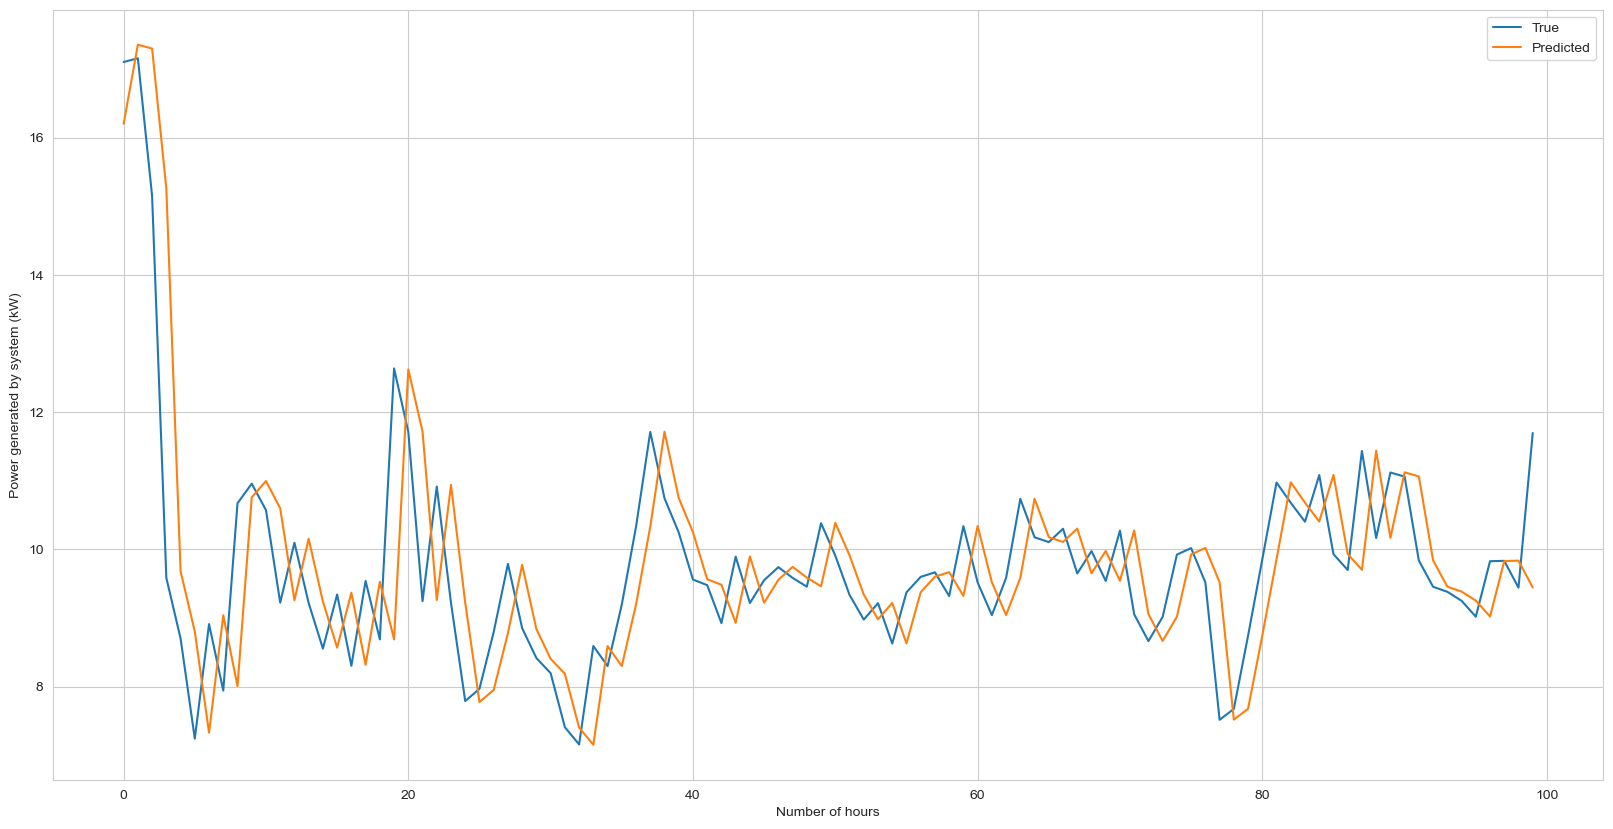

In [39]:
# line plot of observed vs predicted
sns.set_style("whitegrid")
pyplot.figure(figsize=(20,10))
pyplot.plot(expectations_plot[0:100], label="True")
pyplot.plot(predictions_plot[0:100], label="Predicted")
pyplot.legend(loc='upper right')
pyplot.xlabel("Number of hours")
pyplot.ylabel("Power generated by system (kW)")
pyplot.show()

In [40]:
import pickle

In [41]:
Pkl_Filename = "Forcasting_WIndSpeed(E).pkl" 

In [42]:
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(lstm_model, file)

In [43]:
with open(Pkl_Filename, 'rb') as file:  
    Pickled_LR_Model = pickle.load(file)

Pickled_LR_Model